In [31]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import pandas as pd
import numpy as np
from pathlib import Path
from dataloader import LandmarkDataset, SequenceDataset
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

pd.set_option('mode.chained_assignment', None)

find landmark files

In [2]:
# root directory of data
data_root = Path("/home/orel/Storage/Data/K6/")
landmark_files = []
for subdir in os.listdir(data_root):
    for file in os.listdir(data_root/subdir/'Down'):
        if re.match(r"00\d*DeepCut_resnet50_Down2May25shuffle1_1030000\.h5", file):
            lfile = data_root/subdir/'Down'/file
            landmark_files.append(lfile)

# Training the autoencoder

create and train autoencoder model

In [3]:
from simple_autoencoder import Autoencoder, PLAutoencoder
seqlen = 30
model = PLAutoencoder(n_neurons=[2*12*seqlen, 1024, 1024, 512, 32], lr=3e-4, seqlen=seqlen, landmark_files=landmark_files)
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=50, )
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 4 M   


Epoch    35: reducing learning rate of group 0 to 6.0000e-05.


Saving latest checkpoint..


1

compare the original and reconstructed data, each plot for a different feature / coordinate

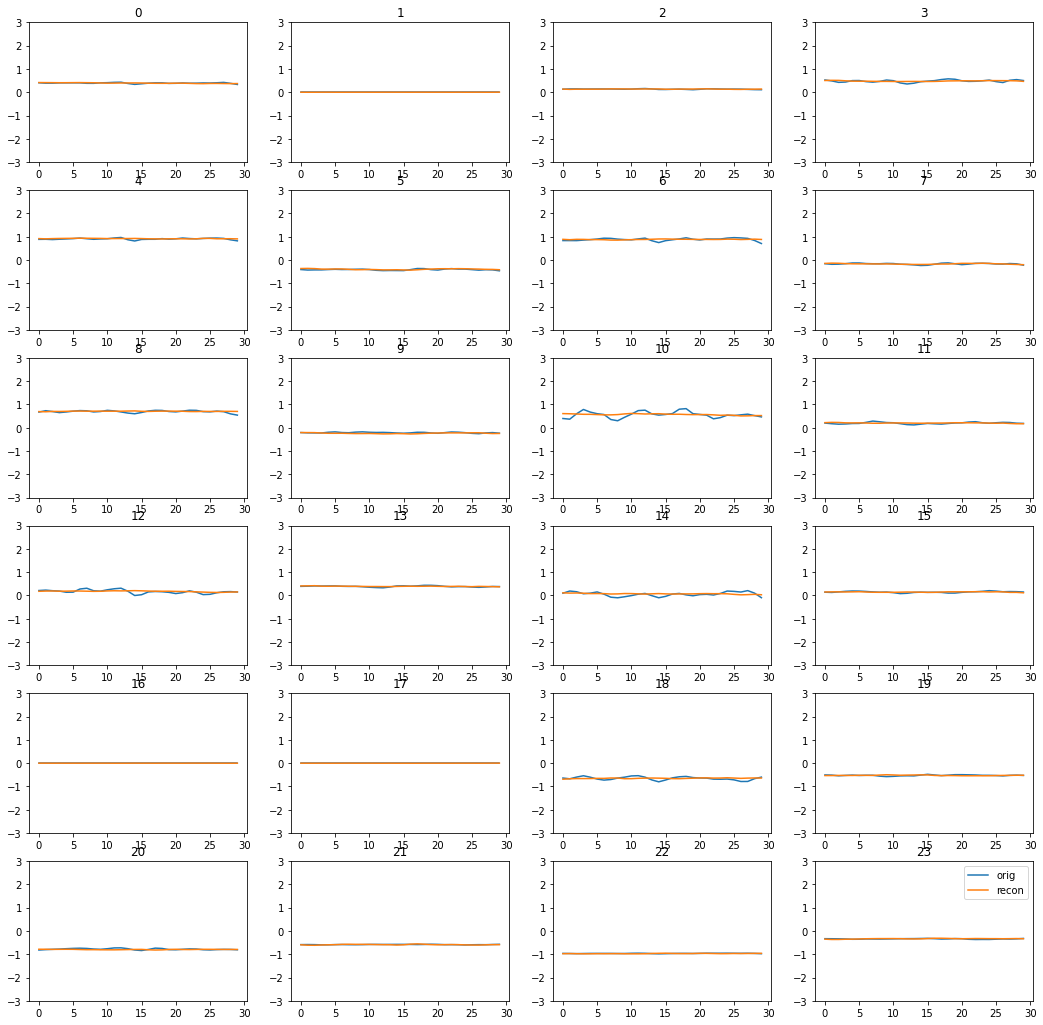

In [9]:
def compare_plot(x, y):
    x = x.reshape(seqlen, 24)
    y = y.reshape(seqlen, 24)
    fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(18, 18))
    for i in range(6):
        for j in range(4):
            idx = 4*i + j
            axes[i][j].plot(x[:,idx], label='orig')
            axes[i][j].plot(y[:,idx], label='recon')
            axes[i][j].set_title(f"{idx}")
            axes[i][j].set_ylim(-3, 3)
    plt.legend()
 
with torch.no_grad():
    bx = next(iter(model.train_dataloader()))
    out = model(bx)
compare_plot(bx[190].cpu().numpy(), out[190].cpu().numpy())

# Clustering the data

loading the landmark coordinates from all videos

In [10]:
landmark_datasets = []
for file in landmark_files:
    try:
        ds = LandmarkDataset(file)
        landmark_datasets.append(ds)
    except OSError:
        pass
coords = [sig.decimate(ds.coords, q=4, axis=0).astype(np.float32) for ds in landmark_datasets]

creating the dataset from all the coordinates

In [11]:
N, n_coords, _ = coords[0].shape
all_data = [crds.reshape(-1, n_coords*2) for crds in coords]
data_lengths = [d.shape[0] - model.seqlen for d in all_data]
video_change_idxs = np.cumsum(data_lengths)[:-1]
all_data = [SequenceDataset(d, seqlen=model.seqlen, diff=False, step=1) for d in all_data]
all_data = ConcatDataset(all_data)

clustering the data and splitting into segments

In [38]:
K = 30
X_encoded = model.model.encode(all_data)
kmeans = KMeans(K)
labels = kmeans.fit_predict(X_encoded)
'''
split the sequence of labels and returns the sequence of segments of the form:
      [(label0, segment_start0, segment_length0), ...]
for example:
44422222227777  ->  [(4, 0, 3), (2, 7), (7, 4)]
'''
def split_labels(labels):
    split_at = np.where(np.diff(labels) != 0)[0] + 1
    sequence = [[seg[0], split_at[i-1]*4 + model.seqlen*2, len(seg)*4] \
                for i, seg in enumerate(np.split(labels, indices_or_sections=split_at))]
    sequence[0][1] = model.seqlen*2
    return sequence

labels_dict = dict(zip(landmark_files, 
                        np.split(labels, indices_or_sections=video_change_idxs)))

data_dict = dict(zip(landmark_files,
                    np.split(all_data, indices_or_sections=video_change_idxs)))

segment_dict = dict(zip(landmark_files, 
                        map(split_labels, np.split(labels, indices_or_sections=video_change_idxs))))


TSNE plot of clusters

In [28]:
sample_idxs = np.random.choice(X_encoded.shape[0], size=10000, replace=False)
X_sample = X_encoded[sample_idxs]
sample_labels = labels[sample_idxs]

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=200)
X_2d = tsne.fit_transform(X_sample)

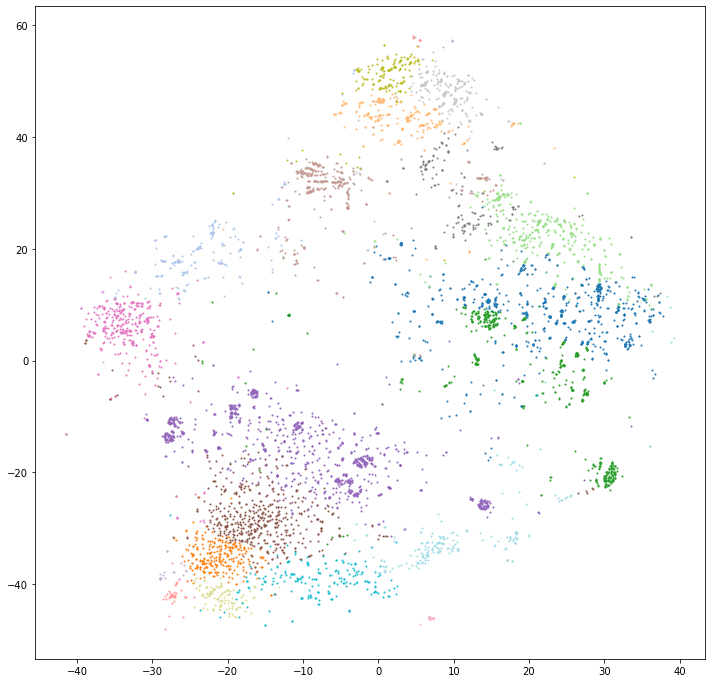

In [36]:
K = 30
sample_labels = labels[sample_idxs]
clusters = {int(i): X_2d[np.where(sample_labels==i)[0]] for i in range(20)}
plt.figure(figsize=(10, 10))
for idx, cluster in clusters.items():
    # print(cluster)
    plt.scatter(cluster[:,0], cluster[:,1], label=idx, s=1, color=cm.tab20.colors[idx])

some plots to show the cluster at each timestep

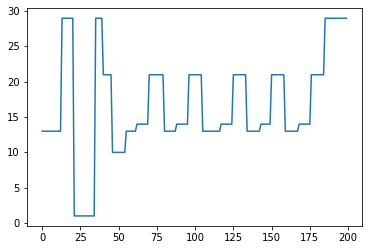

In [70]:
lbls = labels_dict[landmark_files[6]]
segs = segment_dict[landmark_files[6]]
plt.plot(lbls[:200])

In [140]:
np.where(np.diff(lbls[:200]) != 0)

(array([ 12,  20,  34,  39,  45,  54,  61,  69,  79,  87,  95, 104, 116,
        124, 133, 142, 149, 158, 167, 175, 184]),)

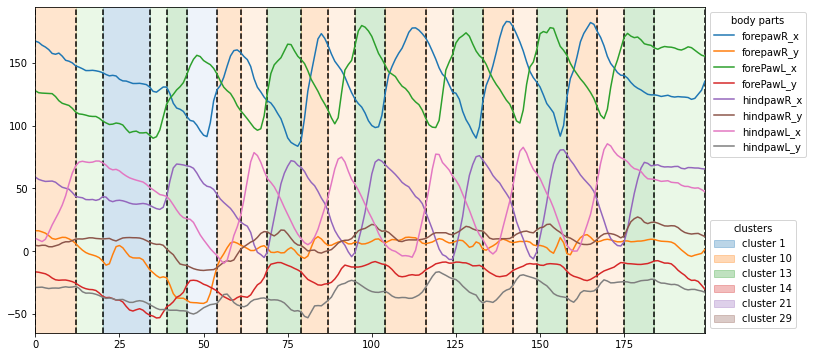

In [236]:


bodyparts_dict = dict(zip(landmark_datasets[0].body_parts, range(len(landmark_datasets[0]))))
def plot_segments(axis, vid_file_idx, start_idx, end_idx, bparts):
    bparts_idxs = [bodyparts_dict[bp] for bp in bparts]
    plot_coords = coords[vid_file_idx][start_idx + model.seqlen//2: end_idx + model.seqlen//2, bparts_idxs]
    for i, body_part in enumerate(bparts):
        axis.plot(plot_coords[:,i,0], label=f"{body_part}_x")
        axis.plot(plot_coords[:,i,1], label=f"{body_part}_y")
    ymin, ymax = axis.get_ybound()
    lbls = labels_dict[landmark_files[vid_file_idx]][start_idx: end_idx]
    label_dict = dict(zip(list(set(lbls)), range(len(set(lbls)))))
    segment_edges = np.where(np.diff(lbls) != 0)[0]
    segment_edges = np.append(0, segment_edges)
    segment_edges = np.append(segment_edges, end_idx - start_idx - 1)
    segment_labels = lbls[segment_edges]
    axis.margins(0, 0)
    axis.vlines(segment_edges, ymin=ymin, ymax=ymax, color='black', linestyle='dashed')
    for i in range(1, len(segment_edges)):
        cluster_color = cm.tab20(label_dict[lbls[segment_edges[i]]], alpha=0.2)
        axis.fill_betweenx([ymin, ymax], segment_edges[i-1], segment_edges[i], color=cluster_color)
    color_patches = [mpatches.Patch(color=cm.tab10(lbl, alpha=0.3), label=f'cluster {i}') for i, lbl in label_dict.items()]
    cluster_color_legend = axis.legend(handles=color_patches, bbox_to_anchor=(1.0, 0.0), loc='lower left', title='clusters')
    ax = plt.gca().add_artist(cluster_color_legend)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, bbox_to_anchor=(1.0, 1), title="body parts")
    
    
plt.figure(figsize=(12, 6))
ax = plt.subplot()
plot_segments(ax, 6, 0, 200, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])

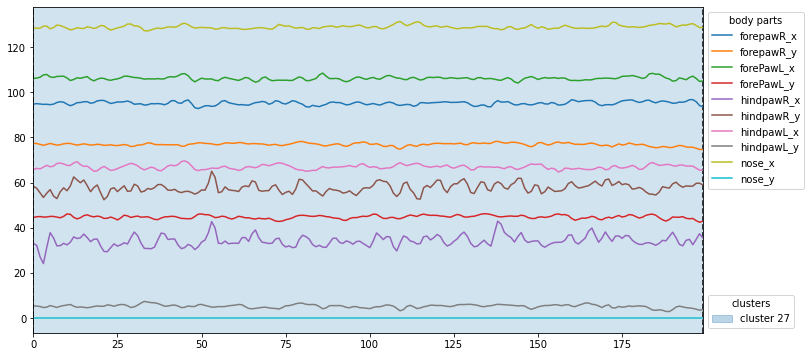

In [242]:
plt.figure(figsize=(12, 6))
ax = plt.subplot()
plot_segments(ax, 6, 10000, 10200, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL', 'nose'])

In [195]:
segment_labels

array([13, 13, 29,  1, 29, 21, 10, 13, 14, 21, 13, 14, 21, 13, 14, 21, 13,
       14, 21, 13, 14, 21, 29], dtype=int32)

In [138]:
cm.tab10(2, alpha=0.2)

(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.2)

In [136]:
?cm.tab10

Signature:      cm.tab10(X, alpha=None, bytes=False)
Type:           ListedColormap
String form:    <matplotlib.colors.ListedColormap object at 0x7fd09edae9a0>
File:           ~/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/colors.py
Docstring:     
Colormap object generated from a list of colors.

This may be most useful when indexing directly into a colormap,
but it can also be used to generate special colormaps for ordinary
mapping.

Parameters
----------
colors : list, array
    List of Matplotlib color specifications, or an equivalent Nx3 or Nx4
    floating point array (*N* rgb or rgba values).
name : str, optional
    String to identify the colormap.
N : int, optional
    Number of entries in the map. The default is *None*, in which case
    there is one colormap entry for each element in the list of colors.
    If ::

        N < len(colors)

    the list will be truncated at *N*. If ::

        N > len(colors)

    the list will be extended by repetition.
Init do

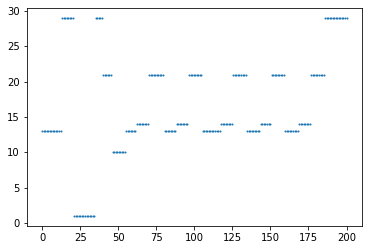

In [67]:
plt.scatter(np.linspace(0, 200, num=200), lbls[:200], s=1.0)

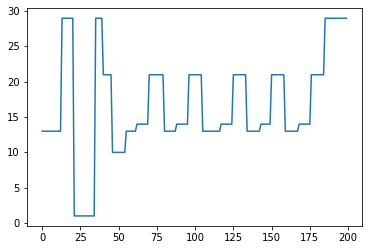

In [60]:
lbls = labels_dict[landmark_files[6]]
plt.plot(lbls[:200])

some histogram plots of lengths of some of the clusters

In [ ]:
from collections import defaultdict
segments = split_labels(labels)
segment_lengths = defaultdict(list)
for seg in segments:
    if seg[2] < 200:
        segment_lengths[seg[0]].append(seg[2]/(4*60))
    
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(8, 12), sharex=True)
for i, cl in enumerate([3, 12, 13, 22]):
    axes[i].hist(segment_lengths[cl], bins=20, density=True)
    axes[i].set_xlim(0, 0.5)

# Saving clips of clusters from the videos

In [ ]:
import cv2 as cv
import importlib
import random
import clip_videos
from collections import defaultdict
importlib.reload(clip_videos)

# save clips for each cluster from a single video
def save_clips(landmarks_file, cluster_segments, save_dir, min_seg_len=10):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    video_file = re.sub(r'DeepCut.*\.h5', '.MP4', landmarks_file.name)
    video_file = landmarks_file.parent / video_file
    assert os.path.exists(video_file)
    cluster_frames = defaultdict(list)
    for seg in cluster_segments:
        if seg[2] >= min_seg_len:
            cluster_frames[seg[0]].append((seg[1] + seg[2]//2, seg[2]//2))
    cluster_frames = {k: v for k, v in cluster_frames.items() if len(v) >= 15}
    cluster_samples = {c: random.choices(cl, k=15) for c, cl in cluster_frames.items()}
    df = LandmarkDataset(landmarks_file).df
    for cl_id,  cluster in cluster_samples.items():
        mid_frames = [c[0] for c in cluster]
        n_frames = [c[1] for c in cluster]
        n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
        clip_videos.save_collage_with_labels_short(str(video_file), df, mid_frames, n_frames_around=n_frames,
                                             save_file=f'{save_dir}/cluster_{cl_id}.mp4')

save clips from all videos, from each video in a seoperate directory.

In [ ]:
for lfile, segments in segment_dict.items():
    save_dir = f'clusters/sept15/{lfile.name[:4]}'
    if not os.path.exists(save_dir):
        save_clips(lfile, segments, save_dir)

## Not really important

In [ ]:
from collections import defaultdict
import random
split_at = np.where(np.diff(labels) != 0)[0] + 1
sequence = [[s[0], split_at[i-1], len(s)] for i, s in enumerate(np.split(labels, indices_or_sections=split_at))]
sequence[0][1] = 0
seg_lengths = defaultdict(list)
for seg in sequence:
    seg_lengths[seg[0]].append(seg[2])

sequence = [seq for seq in sequence if seq[2] > 5]

cluster_frames = defaultdict(list)
for seq in sequence:
    cluster_frames[seq[0]].append((seq[1]*4 + seq[2]*2, seq[2]*2))

cluster_frames = {c:cl for c, cl in cluster_frames.items() if len(cl)>25}
# len(cluster_frames)
cluster_samples = {c: random.choices(cl, k=15) for c, cl in cluster_frames.items()}

In [ ]:
import cv2 as cv
import importlib
import clip_videos
importlib.reload(clip_videos)

video_file = data_root/'2020-03-23'/'Down'/'0008DeepCut_resnet50_Down2May25shuffle1_1030000_labeled.mp4'

In [ ]:
for cl_id,  cluster in cluster_samples.items():
    n_frames = [c[1] for c in cluster]
    print(cl_id, np.mean(n_frames), np.std(n_frames))

In [ ]:
df = LandmarkDataset(landmarks_file).df
for cl_id,  cluster in cluster_samples.items():
    mid_frames = [c[0] for c in cluster]
    n_frames = [c[1] for c in cluster]
    n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
    print(mid_frames)
    clip_videos.save_collage_with_labels_short(str(video_file), df, mid_frames, n_frames_around=n_frames,
                                         save_file=f'clusters/example_1/cluster_{cl_id}.mp4')

In [ ]:
writer.write(np.zeros())

In [ ]:
!ls clusters/example_1

In [ ]:
# sequence = [seq[0] for seq in sequence]
from collections import defaultdict, Counter

def count_ngrams(sequence, max_n=10):
    N = len(sequence)
    counter = defaultdict(int)
    for k in range(1, max_n):
        for i in range(N-k):
            counter[tuple(sequence[i:i+k])] += 1
    return counter

def segment_sequence(sequence, max_n=5):
    N = len(sequence)
    sequence = tuple(sequence)
    ngram_count = count_ngrams(sequence, max_n=max_n)
    u_arr = np.zeros(N - 1)
    for k in range(0, N - 1):
        u_k = 0
        for n in range(2, min(max_n, k, N-k)):
            s_1, s_2 = ngram_count[sequence[k-n+1:k+1]], ngram_count[sequence[k+1:k+n+1]]
            u_k += np.mean([1 if s_1 >= ngram_count[sequence[k-n+i+1:k+i+1]] else 0 for i in range(1, n)])
            u_k += np.mean([1 if s_2 >= ngram_count[sequence[k-n+i+1:k+i+1]] else 0 for i in range(1, n)])
        u_arr[k] = u_k / max_n / 2
    
    sequence = list(sequence)
    segments = []
    prev_idx = 0
    for idx in range(1, N-1):
        if u_arr[idx-1] < u_arr[idx] and u_arr[idx+1] < u_arr[idx]:
            segments.append(sequence[prev_idx:idx+1])
            prev_idx = idx+1

    segments.append(sequence[prev_idx:])
    return segments

segments = segment_sequence(sequence, max_n=10)

In [ ]:
Counter(map(tuple, segments)).most_common(30)

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[:2000])

In [ ]:
labels[:100]
27, 8, 26, 4, 10, 27, 8, 26, 4, 10, 27, 8, 26

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[3*10**4+1500:3*10**4+3000])

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[10**5+1500:10**5+3000])
# plt.plot(labels[250:400])

In [ ]:
re.search(r"(a+b+c+)+", "daaabbbccabc")

In [ ]:
chars = [chr(i) for i in range(ord('A'), ord('Z'))] + [chr(i) for i in range(ord('a'), ord('z'))]
labels_string = ''.join([chars[l] for l in labels])
labels_string[280:400]

In [ ]:
pat = re.compile(r"(K+Q+M+d+b+)+")
spans = [match.span() for match in re.finditer(pat, labels_string)]
span_lengths = [span[1] - span[0] for span in spans]
spans[3] 

In [ ]:
pat = re.compile(r"K+(?!Q*K+)")
fspans = [match.span() for match in re.finditer(pat, labels_string)]
fspans = [(max(0, s[0]-30), s[1]+30) for s in fspans]
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(18, 20))
for i in range(10):    
    for ipart, part in enumerate(landmarks_data.body_parts):
        if part in ['forepawR', 'forePawL', 'hindpawR', 'hindpawL']:
            axes[i][0].plot(coords[fspans[i][0]+15: fspans[i][1]+15,ipart,0], label=f"{part}_x")
            axes[i][0].plot(coords[fspans[i][0]+15: fspans[i][1]+15,ipart,1], label=f"{part}_y")
    axes[i][1].plot(labels[slice(*fspans[i])])
    axes[i][0].legend(loc='right')

In [ ]:
print(len(re.findall(r"K+(?!K*Q+)", labels_string)))
print(len(re.findall(r"K+Q+(?!Q*M+)", labels_string)))
print(len(re.findall(r"K+Q+M+(?!M*d+)", labels_string)))
print(len(re.findall(r"K+Q+M+d+(?!d*b+)", labels_string)))


In [ ]:
fig, axes = plt.subplots(nrows=50, ncols=2, figsize=(18, 200))
for i in range(50):    
    for ipart, part in enumerate(landmarks_data.body_parts):
        if part in ['forepawR', 'forePawL', 'hindpawR', 'hindpawL']:
            axes[i][0].plot(coords[spans[i][0]+15: spans[i][1]+15,ipart,0], label=f"{part}_x")
            axes[i][0].plot(coords[spans[i][0]+15: spans[i][1]+15,ipart,1], label=f"{part}_y")
    axes[i][1].plot(labels[slice(*spans[i])])
    axes[i][0].legend(loc='right')

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[:1000])

In [ ]:
n_clusters = len(set(labels))
transition_matrix = np.zeros((n_clusters, n_clusters))
for i in range(len(labels) - 1):
    transition_matrix[labels[i], labels[i+1]] += 1.

np.fill_diagonal(transition_matrix, val=0)

transition_matrix /= transition_matrix.sum(axis=0, keepdims=True)
plt.imshow(transition_matrix)

In [ ]:
def split(idx_arr):
    to_split = np.where(np.abs(np.diff(idx_arr)) > 1)[0] + 1
    return np.split(idx_arr, indices_or_sections=to_split)
behaviors = [split(np.where(y_gold==lbl)[0]) for lbl in set(y_gold)]
sections = [np.stack([np.mean(X_encoded[sec], axis=0) for sec in beh]) for beh in behaviors]
sections[1].shape